In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nplin
import itertools

In [2]:
def operators(s):
    #generate terms in the energy function
    n_seq,n_var = s.shape
    ops = np.zeros((n_seq,n_var+int(n_var*(n_var-1)/2.0)))

    jindex = 0
    for index in range(n_var):
        ops[:,jindex] = s[:,index]
        jindex +=1

    for index in range(n_var-1):
        for index1 in range(index+1,n_var):
            ops[:,jindex] = s[:,index]*s[:,index1]
            jindex +=1
            
    return ops

In [3]:
def energy_ops(ops,w):
    return np.sum(ops*w[np.newaxis,:],axis=1)

In [4]:
def generate_seqs(n_var,n_seq,n_sample=30,large=False,num_large=4):
    samples = np.random.choice([1.0,-1.0],size=(n_seq*n_sample,n_var),replace=True)
    ops = operators(samples)
    n_ops = ops.shape[1]
    w_true = (np.random.rand(ops.shape[1])-0.5)/np.sqrt(float(n_var))

    #putting in some large couplings
    if large and num_large>0: 
        indices_large = np.random.choice(range(n_var,n_ops),size=num_large,replace=False)
        for l_index in range(num_large):
            w_true[indices_large[l_index]] *= 10.0

    sample_energy = energy_ops(ops,w_true)
    p = np.exp(sample_energy)
    p /= np.sum(p)
    out_samples = np.random.choice(np.arange(n_seq*n_sample),size=n_seq,replace=True,p=p)
    
    return w_true,samples[out_samples],p[out_samples],sample_energy[out_samples]

In [5]:
def hopfield_model(s):
    ops = operators(s)
    w = np.mean(ops,axis=0)
    print('hopfield error ',nplin.norm(w-w_true))    
    return w

In [6]:
def boltzmann_machine_exact(w,s,s_all,max_iter=151,alpha=5e-2):
    n_seq,n_var = s.shape
    ops = operators(s)
    cov_inv = np.eye(ops.shape[1])
    ops_obs = np.mean(ops,axis=0)
    ops_model = operators(s_all)

    for iterate in range(max_iter):
        energies_w = energy_ops(ops_model,w)
        probs_w = np.exp(energies_w)
        probs_w /= np.sum(probs_w)
        if iterate%int(max_iter/5.0)==0: 
            print(iterate,nplin.norm(w-w_true)) #,nplin.norm(spin_cov_w-spin_cov_obs))
        w += alpha*cov_inv.dot(ops_obs - np.sum(ops_model*probs_w[:,np.newaxis],axis=0))
        
    print('final ',iterate,nplin.norm(w-w_true))

In [7]:
def boltzmann_machine_sample(w,s,max_iter=151,n_partition=1,alpha=5e-2):
    n_seq,n_var = s.shape
    ops = operators(s)
    cov_inv = np.eye(ops.shape[1])

    ops_obs = np.mean(ops,axis=0)
    samples_part = np.random.choice([1.0,-1.0],size=(n_seq*n_partition,n_var),replace=True)
    ops_model = operators(samples_part)

    for iterate in range(max_iter):
        energies_w = energy_ops(ops_model,w)
        probs_w = np.exp(energies_w)
        probs_w /= np.sum(probs_w)
        if iterate%int(max_iter/5.0)==0: 
            print(iterate,nplin.norm(w-w_true)) #,nplin.norm(spin_cov_w-spin_cov_obs))
        w += alpha*cov_inv.dot(ops_obs - np.sum(ops_model*probs_w[:,np.newaxis],axis=0))
    print('final ',iterate,nplin.norm(w-w_true))

In [8]:
def eps_machine(w,s,eps_scale=.01,max_iter=151,alpha=0.1):
    n_seq,n_var = s.shape
    ops = operators(s)
    n_ops = ops.shape[1]
    cov_inv = np.eye(ops.shape[1])

    for iterate in range(max_iter):        
        energies_w = energy_ops(ops,w)
        probs_w = np.exp(-energies_w*(1-eps_scale))
        probs_w /= np.sum(probs_w)
        ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)
        
        if iterate%int(max_iter/5.0)==0:
            invprob_w = np.exp(-energies_w)
            invprob_w /= np.sum(invprob_w)
            ops_expectation = np.sum(invprob_w[:,np.newaxis]*ops,axis=0)
            print(eps_scale,iterate,nplin.norm(w-w_true),np.log(np.mean(ops_expectation*ops_expectation)))
        #sec_order = np.tanh(w*eps_scale)
        sec_order = w*eps_scale
        w += alpha*cov_inv.dot((ops_expect_w - sec_order))
        
    print('final ',eps_scale,iterate,nplin.norm(w-w_true))

In [9]:
n_var,n_seq = 25,10000
np.random.seed(0)
w_true,seqs,probs,energies = generate_seqs(n_var,n_seq)
#s_all = np.asarray(list(itertools.product([1.0, -1.0], repeat=n_var)))
#s_all.shape

In [10]:
for n_part in range(10000,20001,20000):
    print('n_seq ',n_part)
    print('epsilon ')
    
    #for eps in [0.05,0.1,0.2,0.3,0.6]:
    for eps in [0.6]:        
        np.random.seed(13)
        w_trial3 = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
        eps_machine(w_trial3,seqs[:n_part],eps_scale=eps)
        
    print('Hopfield ')
    w_hopfield=hopfield_model(seqs[:n_part])

    print('Boltzmann (sample) ')
    np.random.seed(13)
    w_trial1 = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
    boltzmann_machine_sample(w_trial1,seqs[:n_part])

    # print('Boltzmann (exact) ')
    # np.random.seed(13)
    # w_trial2 = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
    # boltzmann_machine_exact(w_trial2,seqs[:n_part],s_all)  

n_seq  10000
epsilon 
0.6 0 5.533558253678198 -0.4398340975128608
0.6 30 0.3591310729257488 -7.940224647525945
0.6 60 0.2171228567624111 -9.045971911528738
0.6 90 0.21731826296617326 -9.068705534015985
0.6 120 0.2173752624136624 -9.070268418727283
0.6 150 0.21737946765318267 -9.070397388870289
final  0.6 150 0.2173794950759036
Hopfield 
hopfield error  0.33008501534485185
Boltzmann (sample) 
0 5.533558253678198
30 2.5105062221101884
60 1.1780687046276972
90 0.6475072939887058
120 0.4579894903126848
150 0.3995353491032548
final  150 0.39859283997085637


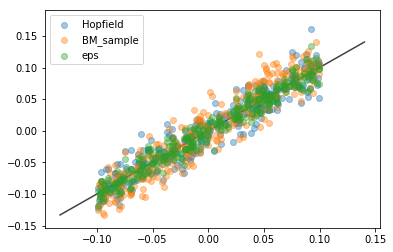

In [11]:
fig, ax = plt.subplots()    
lims = [np.min([w_true, w_trial1]), np.max([w_true, w_trial1])]
ax.scatter(w_true,w_hopfield,label='Hopfield', alpha=0.4)
ax.scatter(w_true,w_trial1,label='BM_sample',alpha=0.4)
#ax.scatter(w_true,w_trial2,label='BM_exact',alpha=0.4)
ax.scatter(w_true,w_trial3,label='eps',alpha=0.4)
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.legend()
plt.show()